# Uncertainty partitioning

Here we estimate the sources of uncertainty for an ensemble of climate model projections. The data is the same as used in the [IPCC WGI AR6 Atlas](https://github.com/IPCC-WG1/Atlas). 

## Fetch data
We'll only fetch a small sample of the full ensemble to illustrate the logic and data structure expected by the partitioning algorith.

In [1]:
from __future__ import annotations

import matplotlib as mpl
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt

import xclim.ensembles

# The directory in the Atlas repo where the data is stored
# host = "https://github.com/IPCC-WG1/Atlas/raw/main/datasets-aggregated-regionally/data/CMIP6/CMIP6_tas_land/"
host = "https://raw.githubusercontent.com/IPCC-WG1/Atlas/main/datasets-aggregated-regionally/data/CMIP6/CMIP6_tas_land/"

# The file pattern, e.g. CMIP6_ACCESS-CM2_ssp245_r1i1p1f1.csv
pat = "CMIP6_{model}_{scenario}_{member}.csv"

In [2]:
# Here we'll download data only for a very small demo sample of models and scenarios.

# Download data for a few models and scenarios.
models = ["ACCESS-CM2", "CMCC-CM2-SR5", "CanESM5"]

# The variant label is not always r1i1p1f1, so we need to match it to the model.
members = ["r1i1p1f1", "r1i1p1f1", "r1i1p1f1"]

# GHG concentrations and land-use scenarios
scenarios = ["ssp245", "ssp370", "ssp585"]

data = []
for model, member in zip(models, members):
    for scenario in scenarios:
        url = host + pat.format(model=model, scenario=scenario, member=member)

        # Fetch data using pandas
        df = pd.read_csv(url, index_col=0, comment="#", parse_dates=True)["world"]
        # Convert to a DataArray, complete with coordinates.
        da = (
            xr.DataArray(df)
            .expand_dims(model=[model], scenario=[scenario])
            .rename(date="time")
        )
        data.append(da)

## Create an ensemble 

Here we combine the different models and scenarios into a single DataArray with dimensions `model` and `scenario`. Note that the names of those dimensions are important for the uncertainty partitioning algorithm to work. 

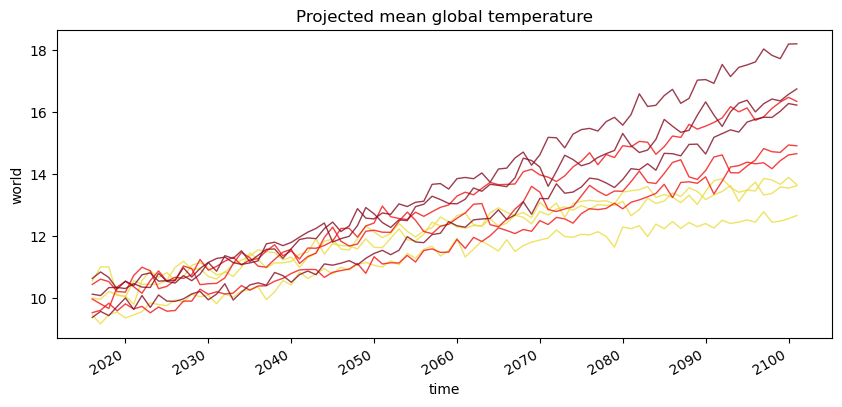

In [3]:
# Combine DataArrays from the different models and scenarios into one.
ens_mon = xr.combine_by_coords(data)["world"]

# Then resample the monthly time series at the annual frequency
ens = ens_mon.resample(time="Y").mean()
ssp_col = {
    "ssp126": "#1d3354",
    "ssp245": "#eadd3d",
    "ssp370": "#f21111",
    "ssp585": "#840b22",
}
plt.figure(figsize=(10, 4))
for scenario in ens.scenario:
    for model in ens.model:
        ens.sel(scenario=scenario, model=model).plot(
            color=ssp_col[str(scenario.data)], alpha=0.8, lw=1
        )
plt.title("Projected mean global temperature");

Now we're able to partition the uncertainties between scenario, model, variability using the approach from Hawkins and Sutton. 

By default, the function uses the period 1971-2000 to compute the baseline. Since we haven't download historical simulation, here we'll just use the beginning of the future simulations. 

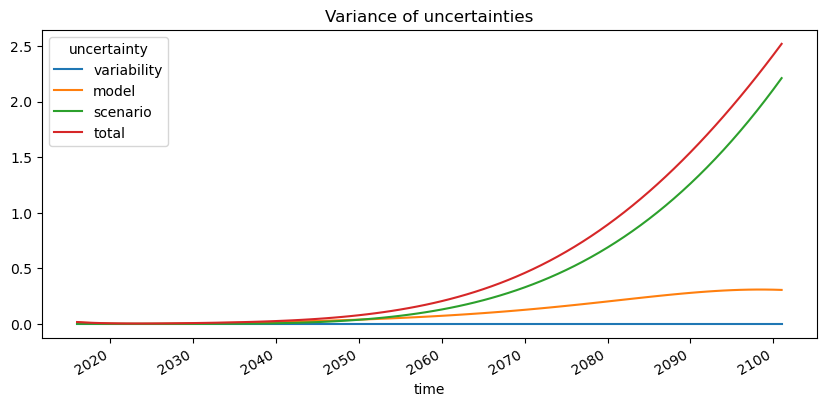

In [4]:
mean, uncertainties = xclim.ensembles.hawkins_sutton(ens, baseline=("2016", "2030"))
plt.figure(figsize=(10, 4))
uncertainties.plot(hue="uncertainty")
plt.title("Variance of uncertainties");

From there, it's relatively straightforward to compute the relative strength of uncertainties, and create graphics similar to those found in scientific papers. 

In [5]:
colors = {
    "variability": "#DC551A",
    "model": "#2B2B8B",
    "scenario": "#275620",
    "total": "k",
}
names = {"variability": "Internal variability"}


def graph_fraction_of_total_variance(variance, ref="2000", ax=None):
    """Figure from Hawkins and Sutton (2009) showing fraction of total variance.
    Parameters
    ----------
    variance: xr.DataArray
      Variance over time of the different sources of uncertainty.
    ref: str
      Reference year. Defines year 0.
    ax: mpl.axes.Axes
      Axes in which to draw.
    Returns
    -------
    mpl.axes.Axes
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1)

    # Compute fraction
    da = variance / variance.sel(uncertainty="total") * 100

    # Select data from reference year onward
    da = da.sel(time=slice(ref, None))

    # Lead time coordinate
    lead_time = add_lead_time_coord(da, ref)

    # Draw areas
    y1 = da.sel(uncertainty="model")
    y2 = da.sel(uncertainty="scenario") + y1
    ax.fill_between(lead_time, 0, y1, color=colors["model"])
    ax.fill_between(lead_time, y1, y2, color=colors["scenario"])
    ax.fill_between(lead_time, y2, 100, color=colors["variability"])

    # Draw black lines
    ax.plot(lead_time, np.array([y1, y2]).T, color="k", lw=2)

    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(20))
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(n=5))

    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(n=2))

    ax.set_xlabel(f"Lead time [years from {ref}]")
    ax.set_ylabel("Fraction of total variance [%]")

    ax.set_ylim(0, 100)

    return ax


def add_lead_time_coord(da, ref):
    """Add a lead time coordinate to the data. Modifies da in-place."""
    lead_time = da.time.dt.year - int(ref)
    da["Lead time"] = lead_time
    da["Lead time"].attrs["units"] = f"years from {ref}"
    return lead_time

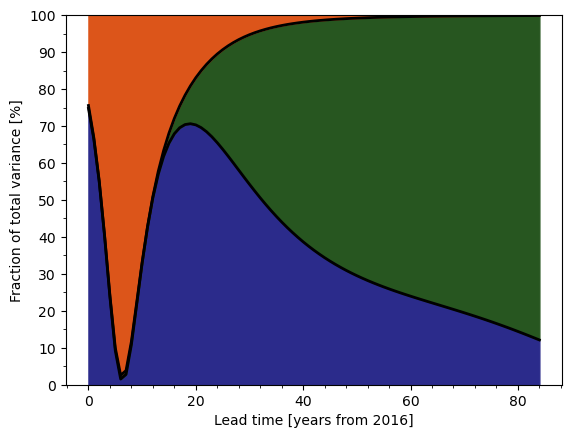

In [6]:
graph_fraction_of_total_variance(uncertainties, ref="2016");